In [216]:
import numpy as np
from netCDF4 import Dataset 
import matplotlib.pyplot as plt 
import myfunctions as mf
from matplotlib.pyplot import cm
import matplotlib as mpl

# Data Locations

In [217]:
## Datastore directory 
datastore = "/exports/csce/datastore/geos/users/s1215319/paper3/version2/"
## TLM Matrix directory
tlm_dir = datastore + "tlmfiles/o2sensitivity/"

# Time Parameters

In [218]:
ls_study = [40, 133, 248, 328]

# Adjoint Sensitivity Analysis

In [223]:
########################################
## Input
########################################

### Forecast and backtrace time-steps
forecast_localtime = 23.
backtrace_localtime =12.

### Forecast Sol
forecast_sol = 3

### Timesteps per sol
solstep = 48

### Read Tracer Indexes

In [224]:
### Text file of TLM indexes
txtfile_name = "standard/tracer_index.txt"
txtfile = open(tlm_dir + txtfile_name,"r")

indx_file_lines = txtfile.readlines()

### Initial local time
lt_init = float( indx_file_lines[0].split()[-1])

### Number of tracers 
nqmx = int(indx_file_lines[3].split()[-1])

### Number of model layers
nlayermx = int(indx_file_lines[4].split()[-1])

### Number of model time-steps
ndt = int(indx_file_lines[2].split()[-1])

### Local Time Array
lt = np.empty(ndt)
lt[0] = lt_init
for t in range(1,ndt):
    lt[t] = lt[t-1] + 24./48. 
    if ( lt [t] >= 24. ):
        lt[t] = 0.
        
### Indexes of tracers within TLM vector space
tlm_idx = {}
for i in range(0,nqmx):
    tracer = indx_file_lines[6+i].split()[0]
    idx = int(indx_file_lines[6+i].split()[-1])

    tlm_idx[tracer] = idx
    
### Forecast Time-step Index
tNi, t_0 = int(np.where( lt[forecast_sol*48 : (forecast_sol+1)*48] == forecast_localtime )[0][0]),\
            int(np.where( lt[forecast_sol*48 : (forecast_sol+1)*48] == backtrace_localtime )[0][0])
t_N = forecast_sol*48 + tNi

### Sensitivity with Altitude

Two figures constructed: sensitivity of surface O2 with respect to INORGANIC compounds [H2O, H2O2, CO2, H] and ORGANIC compounds [CH4, HCHO, CH3OOH, CH3].

##### Model

In [233]:
forecast_element = 'o2'
forecast_layer = 0 

### Type oF Run
runtype = 'standard'

### Forecast Index
Ji = (tlm_idx[forecast_element] - 1)*nlayermx + forecast_layer

### Sensitivity Arrays [Ls, Time, dO2/dY]
Jhats = np.zeros( [4,t_N-t_0,nqmx*nlayermx] )
Jhats[:,-1,Ji] = 1. 

### Loop 1 - Ls 
ls_i=0
for ls in ls_study:
    filename = str(ls) + "Ls_tlm.bin"

    ## =========================================
    ## Extract and re-arrance the adjoint matrix
    ## =========================================
    adjoint_data = np.fromfile(tlm_dir + runtype + "/" + filename , dtype = np.float64(), sep='' )

    adj = np.reshape(adjoint_data,[ndt,nqmx*nlayermx,nqmx*nlayermx])

    ## ====
    ## Trim
    ## ====
    adj = adj[t_0:t_N,:,:]
    
    ### Loop Backwards
    for t in range( (t_N-t_0)-2,t_0-1,-1):
        Jhats[ls_i,t,:] = np.matmul( adj[t,:,:], Jhats[ls_i,t+1,:] )
    
    print(np.max(Jhats[ls_i,:,:]))
    ls_i = ls_i + 1


490957.98750514176
2179859.686063392
517025.9861163618
499252.71732407436


Text(0.5,0.95,'Sensitivity of Surface O$_2$ VMR at Gale Crater\nwith Respect to Organic Compounds\n(Standard CH$_4$ Chemistry)')

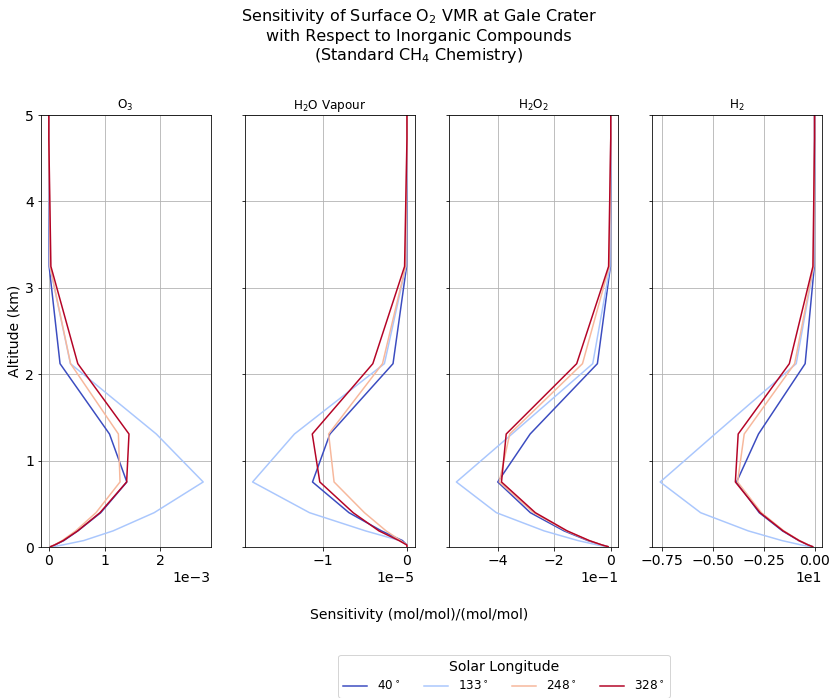

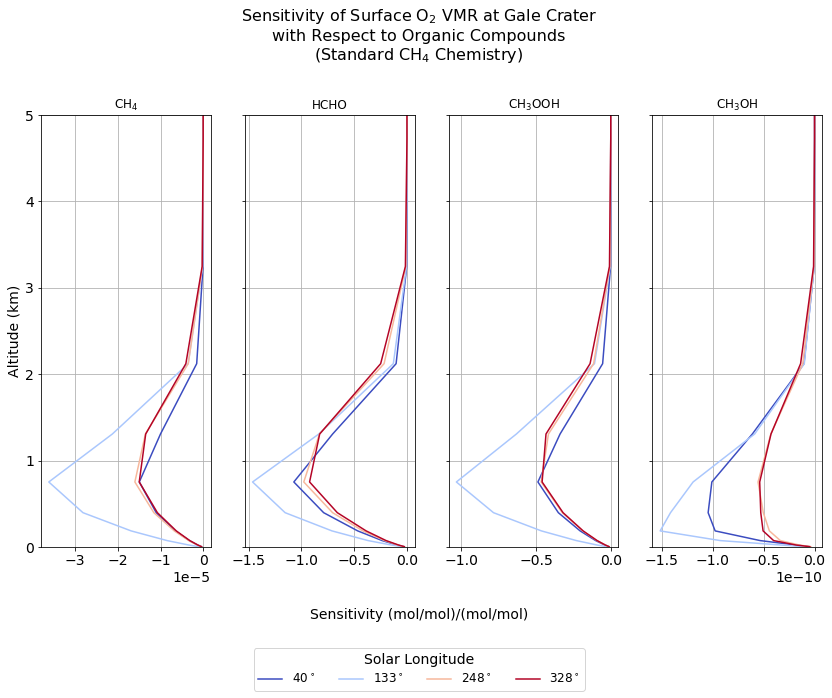

In [235]:
inorganics, organics = ['o3','h2o_vap','h2o2','h2'],  ['ch4','hcho','ch3ooh','ch3oh']

ylim = 5.

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.grid'] = True

fig1,axs1 = plt.subplots(1,len(inorganics), sharey = True)
fig2,axs2 = plt.subplots(1,len(organics), sharey = True)
# 
fig1.set_figheight(10)
fig1.set_figwidth(14)

fig2.set_figheight(10)
fig2.set_figwidth(14)

## Places tracer names in plot title
titlescribe = True

#####################################
### LOOP 1 : Over TLM Solar Longitude
#####################################
## Colors for the Solar Longitude 
color=iter(cm.coolwarm(np.linspace(0,1,4)))
ls_i=0
for lsval in ls_study:
    
    ## Cycle color
    c = next(color)
    
    ## Sensitivity Array
    Jhat = Jhats[ls_i,:,:]

    ## Altitude, from NetCDF model files
    ncdf = Dataset(tlm_dir+runtype+"/ncdf_files/"+str(ls)+"Ls.nc")
    mmean = ncdf.variables['mmean'][:] 
    ## km
    alt = ncdf.variables['altitude'][:]
    
    # Create a conversion vector of equal size to the sensitivity vector
    # ------------------------------------------------------------------
    mmrvmr = np.empty(nqmx*nlayermx)
    
    A = mf.mmol['o2']/mmean[t_N,0]
    B = np.empty(nqmx*nlayermx)
    
    for i in tlm_idx:
        mmol = mf.mmol[i] ## Molar mass of gas 
        idx = (tlm_idx[i]-1)*nlayermx 
        
        B[idx:idx+nlayermx] = mmean[t_0,:]/mmol 
    
    mmrvmr = A*B
        
    ######################
    ### LOOP2 : Inorganics
    ######################
    a=0
    for inorg in inorganics:
        
        ## Index
        i = (tlm_idx[inorg]-1)*nlayermx
        
        ## Plot
        axs1[a].plot(Jhat[t_0,i:i+nlayermx]*mmrvmr[i:i+nlayermx],alt,color=c, label = str(lsval) + "$^\circ$")
        
        ## Title?
        if ( titlescribe ):
            axs1[a].set_title(mf.latex_title(inorg),fontsize=12)
        
        a=a+1
        
    ######################
    ### LOOP3 : Organics
    ######################
    a=0
    for org in organics:
        
        ## Index
        i = (tlm_idx[org]-1)*nlayermx
        
        ## Plot
        axs2[a].plot(Jhat[t_0,i:i+nlayermx]*mmrvmr[i:i+nlayermx],alt,color=c, label = str(lsval) + "$^\circ$")
        
        ## Title?
        if ( titlescribe ):
            axs2[a].set_title(mf.latex_name(org),fontsize=12)
        
        a=a+1
        
    titlescribe = False 
    
    ls_i=ls_i+1
        
        

#############
## Formatting
#############
axs1[-1].set_ylim(0.,ylim)
axs2[-1].set_ylim(0.,ylim)

for a in range(0,4):
    axs1[a].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axs2[a].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

## Legend 
## ------
fig1.subplots_adjust(bottom=0.2,top=0.8)
handles,labels = axs1[0].get_legend_handles_labels()
legend = fig1.legend(handles, labels, bbox_to_anchor=(0.5,0.03),loc='center', bbox_transform = plt.gcf().transFigure, ncol=4,\
          fontsize = 12, title = "Solar Longitude")
legend.get_title().set_fontsize('14') 


## Legend 
## ------
fig2.subplots_adjust(bottom=0.2,top=0.8)
handles,labels = axs2[0].get_legend_handles_labels()
legend = fig2.legend(handles, labels, bbox_to_anchor=(0.5,0.03),loc='center', bbox_transform = plt.gcf().transFigure, ncol=4,\
          fontsize = 12, title = "Solar Longitude")
legend.get_title().set_fontsize('14') 

## Titles and Labels
## =================
axs1[0].set_ylabel("Altitude (km)")
axs2[0].set_ylabel("Altitude (km)")

fig1.text(0.5,0.1,"Sensitivity (mol/mol)/(mol/mol)",fontsize=14, ha='center')
fig2.text(0.5,0.1,"Sensitivity (mol/mol)/(mol/mol)",fontsize=14, ha='center')

fig1.suptitle("Sensitivity of Surface O$_2$ VMR at Gale Crater\nwith Respect to Inorganic Compounds\n(Standard CH$_4$ Chemistry)", fontsize = 16, y= 0.95)
fig2.suptitle("Sensitivity of Surface O$_2$ VMR at Gale Crater\nwith Respect to Organic Compounds\n(Standard CH$_4$ Chemistry)", fontsize = 16, y= 0.95)

In [236]:
fig1.savefig(datastore+"figures/FIG1_O2sens-inorganics_" + runtype + ".png",dpi=500)

In [237]:
fig2.savefig(datastore+"figures/FIG1_O2sens-organics_" + runtype + ".png",dpi=500)